# Partial Dependency Plots - PDP
## TAIC 2 - Atividade 4

Autor: João Vitor Mergulhão

Base de dados usada na atividade: https://www.kaggle.com/datasets/ehsanesmaeili/red-and-white-wine-quality-merged

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler

In [160]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
file_path = "wine_quality_merged.csv"

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "ehsanesmaeili/red-and-white-wine-quality-merged",
  file_path
)

/var/folders/py/_hms0lwn3h70z03wxhxl24jm0000gp/T/ipykernel_60981/3456283325.py:8: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df = kagglehub.load_dataset(


In [161]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6497 non-null   float64
 1   volatile acidity      6497 non-null   float64
 2   citric acid           6497 non-null   float64
 3   residual sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free sulfur dioxide   6497 non-null   float64
 6   total sulfur dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
 12  type                  6497 non-null   object 
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


In [162]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red


In [163]:
df.quality.value_counts()

quality
6    2836
5    2138
7    1079
4     216
8     193
3      30
9       5
Name: count, dtype: int64

## Preparação dos dados

- Separação entre treino e teste
- Normalização dos dados

In [164]:
X = df.drop(columns=["quality"])
y = df["quality"]

X = pd.get_dummies(X, drop_first=True)
feature_names = X.columns.tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Seleção de Features

In [165]:
def calculate_PFI(model, X, y, column_names=None):
  if column_names is None:
    column_names = X.columns.tolist()

  result = permutation_importance(model, X, y,n_repeats=100, random_state=2)

  importances = pd.DataFrame({'importances_mean': result.importances_mean,
                'importances_std':result.importances_std,
                'feature': column_names}).sort_values(by='importances_mean', ascending=False)

  return importances

def plot_PFI(importances, model_name):
  fig, ax = plt.subplots()

  importances.plot.bar(x='feature', y='importances_mean', yerr='importances_std', ax=ax)

  ax.set_title(f"Permutation Feature importance on {model_name}")
  ax.set_ylabel("Mean accuracy decrease")
  fig.tight_layout()
  plt.show()

In [166]:
random_forest_model = RandomForestRegressor(min_samples_leaf=10, random_state=42)
random_forest_model.fit(X_train, y_train)

knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train, y_train)

,n_neighbors,5
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


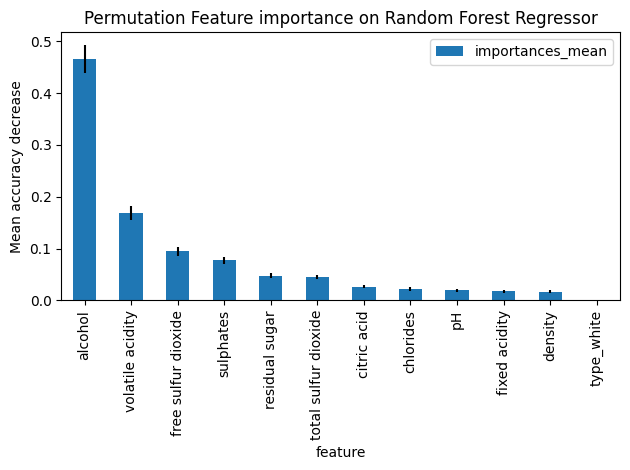

In [167]:
importances = calculate_PFI(random_forest_model, X_test, y_test, feature_names)
plot_PFI(importances, "Random Forest Regressor")

In [168]:
importances.head(3)

,importances_mean,importances_std,feature
10,0.466298,0.026587,alcohol
1,0.169015,0.013234,volatile acidity
5,0.094412,0.008828,free sulfur dioxide


In [171]:
top_3_names = importances.head(3)['feature'].tolist()
top_3_indices = importances.head(3).index.tolist()

print("Features mais importantes:", top_3_names, top_3_indices)

Features mais importantes: ['alcohol', 'volatile acidity', 'free sulfur dioxide'] [10, 1, 5]


## PDP

### Para o Random Forest

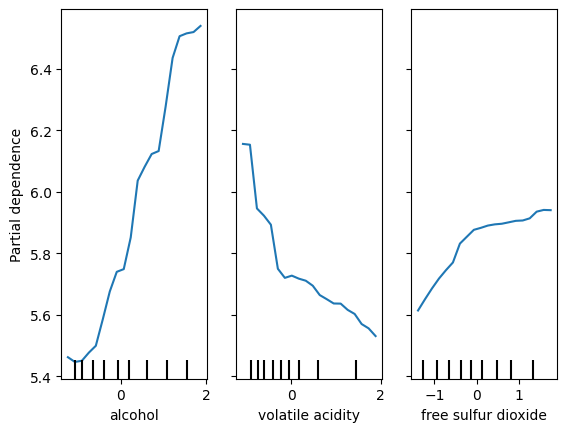

In [185]:
PartialDependenceDisplay.from_estimator(random_forest_model, 
                                        X_test, 
                                        features= top_3_indices, 
                                        feature_names= feature_names, 
                                        grid_resolution=20)
plt.show()

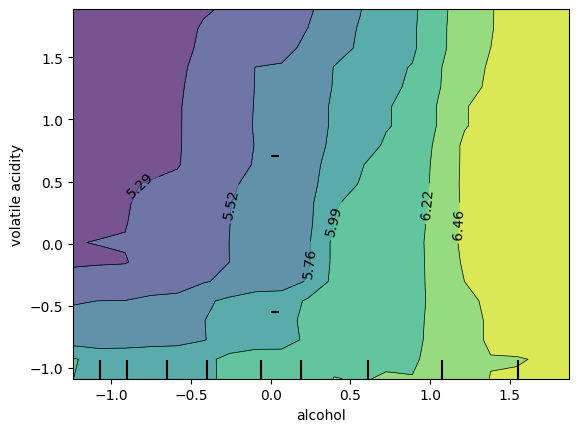

In [188]:
PartialDependenceDisplay.from_estimator(random_forest_model, 
                                        X_test, 
                                        features= [(top_3_indices[0], top_3_indices[1])], 
                                        feature_names= feature_names, 
                                        grid_resolution=20)
plt.show()

### Para o KNN

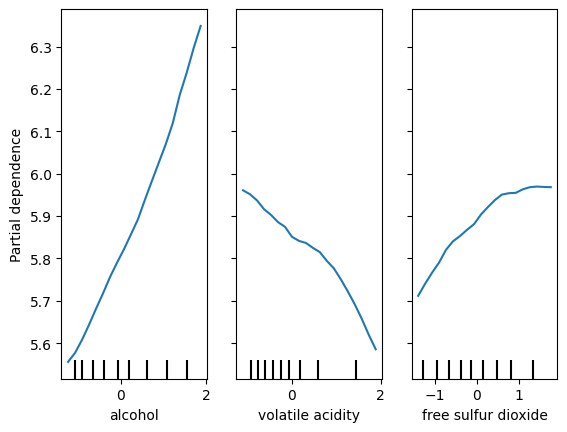

In [192]:
PartialDependenceDisplay.from_estimator(knn_model, 
                                        X_test, 
                                        features= top_3_indices, 
                                        feature_names= feature_names, 
                                        grid_resolution=20)
plt.show()

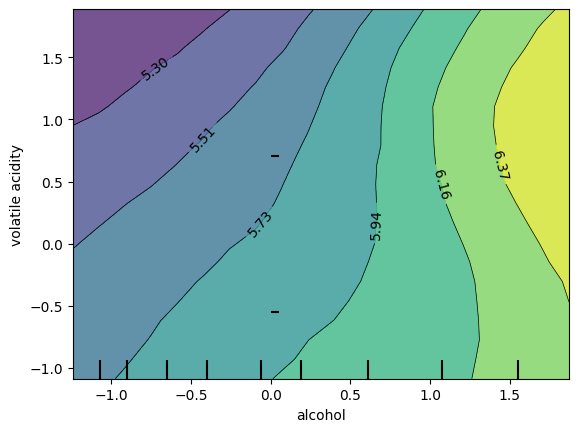

In [189]:
PartialDependenceDisplay.from_estimator(knn_model, 
                                        X_test, 
                                        features= [(top_3_indices[0], top_3_indices[1])], 
                                        feature_names= feature_names, 
                                        grid_resolution=20)
plt.show()

## ICE - Individual Conditional Expectation Plots

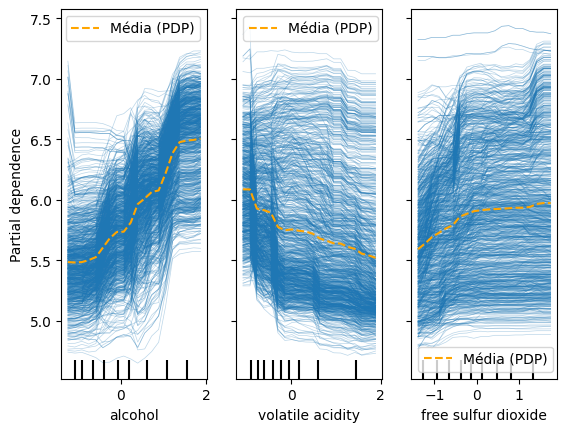

In [ ]:
pdp_line_params = {
    'color': 'orange',         
    'linestyle': '--',      
    'linewidth': 1.5,         
    'label': 'Média (PDP)'  
}

PartialDependenceDisplay.from_estimator(random_forest_model, 
                                        X_test, 
                                        features= top_3_indices, 
                                        feature_names= feature_names, 
                                        grid_resolution=20, 
                                        kind = 'both', 
                                        pd_line_kw=pdp_line_params)
plt.show()

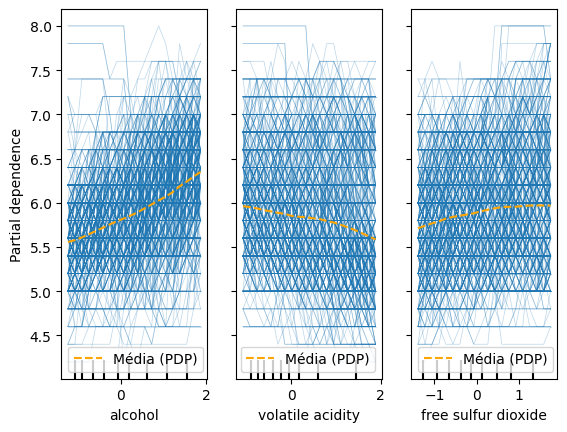

In [190]:
PartialDependenceDisplay.from_estimator(knn_model, 
                                        X_test, 
                                        features= top_3_indices, 
                                        feature_names= feature_names, 
                                        grid_resolution=20, 
                                        kind = 'both', 
                                        pd_line_kw=pdp_line_params)
plt.show()